As we discussed in the class, presynaptic action potentials trigger the <i>release of neurotransmitter</i> that binds to postsynaptic receptors, which elicits a postsynaptic response. If multiple presynaptic action potentials are trigger in quick succession, in most synapses we observe that the postsynaptic responses are quickly reduced in amplitude (<b>short-term synaptic depression</b>) or increased (<b>short-term synaptic facilitation</b>). This is an effect that lasts up to tens of seconds. Here we will look at a mathematical model of short-term synaptic plasticity that captures <b>short-term depression</b>.

<br>
<figure>
    <img src='files/Figures/Synapse_STP.png' width="410" alt='Synapse with short-term synaptic plasticity (depression)' />
    <figcaption><b>Figure 1</b>: Schematic of synapse with short-term depression. The schematic represents the presynapse and neurotransmitter vesicles (blue) and the postsynapse with neurotransmitter receptors (red). Vertical blue lines represent presynaptic spikes. Red traces represent the postsynaptic voltage with excitatory postsynaptic potentials recorded from connection between pyramidal cells in the visual cortex of young mice (Costa et al. 2013). </figcaption>
</figure>


# 1. A model of short-term depression

This notebook implements a simple <b>short-term plasticity</b> model based on the model first introduced in:
<br>
Tsodyks, M., & Markram, H. (1997). The neural code between neocortical pyramidal neurons depends on neurotransmitter release probability. Proc. Natl. Acad. Sci. USA, 94(2), 719–723.
<p>

This model is defined by the following differential equations:
<br>
<center>
<font size="2">
$\begin{equation}
\frac{dR}{dt} = \frac{1-R}{\tau_D} - RU\delta_{\mathrm{spike}}
\end{equation}$
</font>
</center>

where $R$ represents the number of presynaptic vesicles, $\tau_D$ the depression timeconstant, $U$ the vesicle release probability (also called Utilization Factor) and $\delta_{\mathrm{spike}}$ represents the presynaptic spike. The postsynaptic response This can implemented as:
<br>
```python
dR = (1-R)/tau_D - U*R*spikes
R = R + dt*dR
```

The postsynaptic input is given by $A \times R \times U$, where $A$ is the postsynaptic amplitude factor and models the number of postsynaptic receptors.

We model the postsynaptic neuron as a passive neuron (i.e. no spikes and with only a membrane timeconstant) $\frac{dVm}{dt} = \frac{-Vm}{\tau_mem} - ARU\delta_{\mathrm{spike}}$

```python
dVm = -Vm[t]/tau_mem + A*R*U*spikes
Vm[t+1] = Vm[t] + dt*dVm
```

# 2. Playing with the model

## 2.1 Run the model

You are using a Python notebook, which is divided into cells. To run the Tsodyks-Markram STD model you need to select the next cell (by clicking on it) and then pressing SHIFT+ENTER. This will generate a figure at the end of the cell.

## 2.2 Understand the role of the different parameters

The Tsodyks-Markram STD model has three parameters: the release probability (or utilization factor) $U$, the depression timeconstant $\tau_D$ and an amplitude factor $A$. Their values are defined in the following lines:
```python
A = 2 #Amplitude factor
U = 0.7 #Utilization factor/Release probability
tau_D = 100 #Depression timeconstant (ms)
```
and the $\tau_mem$ is the postsynaptic membrane timeconstant
```python
tau_mem = 100 #Membrane timeconstant (ms)
```

Change the values of this variables and run the model to better understand their impact. For example, what is the impact of setting `tau_D = 200` or `tau_D = 20`?

## 2.2 Change the presynaptic spike frequency

The effect of short-term plasticity is frequency-dependent, and becomes more prominent at higher frequencies. Try changing the variable `pre_rate` to 0.1 Hz, what happens? What would you expect to happen if you now set it to 100 Hz?

# 3. Fitting the model to an experiment

See below.

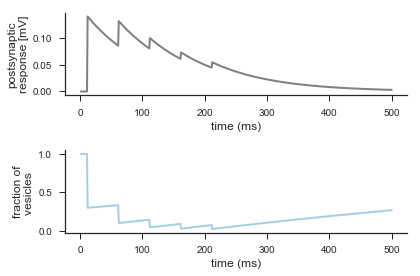

In [101]:
import code
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
plt.rc('axes', labelsize=12)
colorp = "Paired"
colors = sns.color_palette(colorp,10)
sns.set_palette(colorp,10)

#Parameters
A = 2 #Amplitude factor
U = 0.7 #Utilization factor/Release probability
tau_D = 100 #Depression timeconstant (ms)
tau_mem = 10 #Membrane timeconstant (ms)

nspikes = 5
pre_rate = 20 #presynaptic spikes per second (Hz)

simtime = 500


R = np.ones((simtime,1)) #Number of vesicles
Vm = np.zeros((simtime,1)) #Postsynaptic voltage
spikes = np.zeros((simtime,1)) #Spike train

interval = (1000/pre_rate)
last = interval*nspikes+10
spikes[10:last:interval] = 1
#print(spikes)
dt = 0.1


for t in range(1,simtime-1):
    dVm = -Vm[t]/tau_mem + A*R[t]*U*spikes[t]
    Vm[t+1] = Vm[t] + dt*dVm
    
    dR = (1-R[t])/tau_D - U*R[t]*spikes[t]/dt
    R[t+1] = R[t] + dt*dR


fig = plt.figure()

lw = 2
nrows = 2
ncols = 2

#A: Postsynaptic responses
ax_A = plt.subplot2grid((nrows,ncols), (0, 0), colspan=2)

linear_fun = np.arange(1,simtime+1)

ax_A.plot(linear_fun, Vm, label='post. responses', linewidth=lw, color='gray')
ax_A.set(xlabel='time (ms)', ylabel='postsynaptic\nresponse [mV]')#, xlim=(0,30), ylim=(-5,30))

#B: Presynaptic vesicles
ax_B = plt.subplot2grid((nrows,ncols), (1, 0), colspan=2)
ax_B.plot(linear_fun, R, label='pre vesicles', linewidth=lw)
ax_B.set(xlabel='time (ms)', ylabel='fraction of\nvesicles ')#, xlim=(0,30), ylim=(-5,30))

sns.despine()

plt.tight_layout()

#plt.savefig(loadpath + 'Figures/Figure_0_gating_v1.pdf')
plt.show()

# 3. Fitting model to experiments

Now you will try to manually fit the parameters of the model to a real experiment. You will need to adjust all four parameters ($A$, $U$, $\tau_D$ and 'pre_rate') to match the model (black line in Figure 2) to the experimental data (red line in Figure 2). 
<br>
<figure>
    <img src='files/Figures/PCPC_mock_recording.png' width="410" alt='Short-term depression at pyramidal cell synapses' />
    <figcaption><b>Figure 2</b>: Experiment (red) and model (black) of short-term depression. The experimental data is based on short-term depression observed at excitatory synapses between pyramidal-to-pyramidal cells in layer-5 of visual cortex in young mice (Costa et al. 2013). </figcaption>
</figure>

In practice you would be doing this using an automatic optimization method that finds the parameters that  minimize the difference between the model and the data. However this approach might give you a poor understanding of the landscape of possible parameters, for this reason sampling methods have recently been introduced (e.g. <a href="frontiersin.org/articles/10.3389/fncom.2013.00075/full"> Costa et al. 2013</a> and <a href="https://www.frontiersin.org/articles/10.3389/fncom.2016.00116/full">Bird et al. 2016</a>)

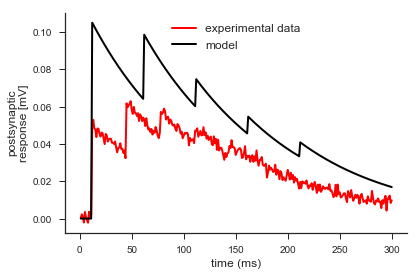

In [122]:
#-- Parameters: begin --#
A = 1.5 #Amplitude factor
U = 0.7 #Utilization factor/Release probability
tau_D = 100 #Depression timeconstant (ms)
pre_rate = 20 #presynaptic spikes per second (Hz)
#-- Parameters: end --#

tau_mem = 10 #Membrane timeconstant (ms)
nspikes = 5 #Number of spikes
simtime = 300

R = np.ones((simtime,1)) #Number of vesicles
Vm = np.zeros((simtime,1)) #Postsynaptic voltage
spikes = np.zeros((simtime,1)) #Spike train

interval = (1000/pre_rate)
last = interval*nspikes+10
spikes[10:last:interval] = 1
#print(spikes)
dt = 0.1


for t in range(1,simtime-1):
    dVm = -Vm[t]/tau_mem + A*R[t]*U*spikes[t]
    Vm[t+1] = Vm[t] + dt*dVm
    
    dR = (1-R[t])/tau_D - U*R[t]*spikes[t]/dt
    R[t+1] = R[t] + dt*dR


fig = plt.figure()

lw = 2
nrows = 1
ncols = 2

#A: Postsynaptic responses
ax_A = plt.subplot2grid((nrows,ncols), (0, 0), colspan=2)

linear_fun = np.arange(1,simtime+1)

#noise = np.random.normal(0, 0.002, Vm.shape)
#data = Vm + noise
#data.tofile('data_STD_PCPC.dat')

data = np.fromfile('data_STD_PCPC.dat', dtype=float)

ax_A.plot(linear_fun, data, label='experimental data', linewidth=lw, color='red')
ax_A.plot(linear_fun, Vm, label='model', linewidth=lw, color='black')
ax_A.set(xlabel='time (ms)', ylabel='postsynaptic\nresponse [mV]')#, xlim=(0,30), ylim=(-5,30))
ax_A.legend(fontsize=12, loc='upper center')

sns.despine()

plt.tight_layout()

plt.show()